# Continual learning - Rehearsal approch

A small experiment with a convolutional network on MNIST and FashionMNIST datasets. The goal is to train the network on MNIST and then on FashionMNIST. The network should be able to learn both datasets without forgetting the first one. 

Compared to the previous experience, we adopt a rehearsal approach. At the end of each epoch when training on FashionMNIST, we train the model on 1 batch of data from MNIST.

One disadvantage is that we need to keep in memory examples from previous task.

In [123]:
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, log_loss
import numpy as np

In [124]:
batch_size = 128

mnist_epochs = 15
fashion_epochs = 15

mnist = True
fashion = True
rehearsal = True
rehearsal_size = 4096

In [125]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [126]:
# import MNIST
mnist_train_data = torchvision.datasets.MNIST(
    root="./mnist",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
test_data = torchvision.datasets.MNIST(
    root="./mnist",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

print(mnist_train_data.data.shape)

# sample subsample images
# train_data = torch.utils.data.Subset(train_data, range(subsample))
# test_data = torch.utils.data.Subset(test_data, range(subsample))
mnist_train_dataloader = DataLoader(
    mnist_train_data, batch_size=batch_size, shuffle=True
)
mnist_test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

torch.Size([60000, 28, 28])


In [127]:
idxs = np.arange(60_000)
np.random.shuffle(idxs)

rehearsal_data = torch.utils.data.Subset(mnist_train_data, idxs[:rehearsal_size])
rehearsal_dataloader = DataLoader(rehearsal_data, batch_size=batch_size, shuffle=True)

In [128]:
# import FashionMNIST
train_data = torchvision.datasets.FashionMNIST(
    root="./fashion",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
test_data = torchvision.datasets.FashionMNIST(
    root="./fashion",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

print(train_data.data.shape)

# sample subsample images
# train_data = torch.utils.data.Subset(train_data, range(subsample))
# test_data = torch.utils.data.Subset(test_data, range(subsample))
fashion_train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
fashion_test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

torch.Size([60000, 28, 28])


In [129]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 4096)
        self.bn1 = nn.BatchNorm1d(4096)

        self.fc2 = nn.Linear(4096, 4096)
        self.bn2 = nn.BatchNorm1d(4096)

        self.fc3 = nn.Linear(4096, 10)
        self.bn3 = nn.BatchNorm1d(10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.bn1(self.fc1(x))
        x = self.bn2(self.fc2(x))
        return torch.softmax(self.bn3(self.fc3(x)), dim=1)

In [130]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2, stride=2, bias=False)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, padding=2, stride=2, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 64, 10)
        self.bn3 = nn.BatchNorm1d(10)

    def forward(self, x):
        # convolutions
        x = self.bn1(self.conv1(x))
        x = torch.relu(x)
        x = self.bn2(self.conv2(x))
        x = torch.relu(x)
        # classifier - MNIST
        x = x.view(x.size(0), -1)
        return torch.softmax(self.bn3(self.fc1(x)), dim=1)

In [131]:
def evaluate_mnist(verbose=1):
    cnn.eval()
    # evaluate on test set and calculate f1 score
    y_pred = torch.empty(0, dtype=torch.long).to(device)
    y_test = torch.empty(0, dtype=torch.long).to(device)
    for _, (X_batch, y_batch) in enumerate(mnist_test_dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = cnn(X_batch)
        y_pred = torch.cat((y_pred, torch.argmax(output, dim=1)))
        y_test = torch.cat((y_test, y_batch))
    score = f1_score(y_test.cpu(), y_pred.cpu(), average="macro")
    if verbose:
        print("Fashion - F1 score", score)
    return score

In [132]:
def evaluate_fashion(verbose=1):
    cnn.eval()
    # evaluate on test set and calculate f1 score
    y_pred = torch.empty(0, dtype=torch.long).to(device)
    y_test = torch.empty(0, dtype=torch.long).to(device)
    for _, (X_batch, y_batch) in enumerate(fashion_test_dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = cnn(X_batch)
        y_pred = torch.cat((y_pred, torch.argmax(output, dim=1)))
        y_test = torch.cat((y_test, y_batch))
    score = f1_score(y_test.cpu(), y_pred.cpu(), average="macro")
    if verbose:
        print("Fashion - F1 score", score)
    return score

In [133]:
cnn = NN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-3)

mnist_scores = []
fashion_scores = []

# MNIST
mnist_losses = []
if mnist:
    print("--- MNIST ---")
    cnn.train()
    for epoch in range(mnist_epochs):
        for _, (X_batch, y_batch) in enumerate(mnist_train_dataloader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = cnn(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} - loss", loss.item())
        mnist_losses.append(loss.item())
        mnist_scores.append(evaluate_mnist(verbose=0))
        fashion_scores.append(evaluate_fashion(verbose=0))

    print("--- Scores ---")
    evaluate_fashion()
    evaluate_mnist()

--- MNIST ---
Epoch 0 - loss 1.7627573013305664
Epoch 1 - loss 1.5966633558273315
Epoch 2 - loss 1.5352715253829956
Epoch 3 - loss 1.5644397735595703
Epoch 4 - loss 1.565083622932434
Epoch 5 - loss 1.5638993978500366
Epoch 6 - loss 1.5859394073486328
Epoch 7 - loss 1.6263598203659058
Epoch 8 - loss 1.5762680768966675
Epoch 9 - loss 1.6018701791763306
Epoch 10 - loss 1.627760887145996
Epoch 11 - loss 1.596528172492981
Epoch 12 - loss 1.5990341901779175
Epoch 13 - loss 1.5965681076049805
Epoch 14 - loss 1.6277209520339966
--- Scores ---
Fashion - F1 score 0.03976558121777974
Fashion - F1 score 0.8303396861143544


In [134]:
# FashionMNIST
if fashion:
    print("--- FashionMNIST ---")

    cnn.train()
    for epoch in range(fashion_epochs):
        for _, (X_batch, y_batch) in enumerate(fashion_train_dataloader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = cnn(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

        if rehearsal:
            # at the end of an epoch, retrain on random samples from MNIST
            for _, (X_batch, y_batch) in enumerate(rehearsal_dataloader):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                output = cnn(X_batch)
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()

        mnist_scores.append(evaluate_mnist(verbose=0))
        fashion_scores.append(evaluate_fashion(verbose=0))
        print(f"Epoch {epoch} - loss", loss.item())

    print("--- Scores ---")
    evaluate_mnist()
    evaluate_fashion()

--- FashionMNIST ---
Epoch 0 - loss 1.9008831977844238
Epoch 1 - loss 1.7692569494247437
Epoch 2 - loss 1.7278555631637573
Epoch 3 - loss 1.7245539426803589
Epoch 4 - loss 1.675480842590332
Epoch 5 - loss 1.6935821771621704
Epoch 6 - loss 1.7174725532531738
Epoch 7 - loss 1.6678684949874878
Epoch 8 - loss 1.7054095268249512
Epoch 9 - loss 1.612975835800171
Epoch 10 - loss 1.6426078081130981
Epoch 11 - loss 1.6784453392028809
Epoch 12 - loss 1.5847963094711304
Epoch 13 - loss 1.6532871723175049
Epoch 14 - loss 1.6256945133209229
--- Scores ---
Fashion - F1 score 0.7927265227257292
Fashion - F1 score 0.8119821936429423


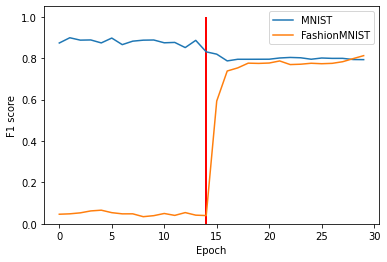

In [136]:
plt.figure()
plt.plot(mnist_scores, label="MNIST")
plt.plot(fashion_scores, label="FashionMNIST")
plt.bar(mnist_epochs - 1, height=1, width=0.2, color="r")
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.legend()
# savefig
plt.savefig("rehearsal.png")
plt.show()